In [500]:
import random
from Hourbid import *
from Fibid import *
from blockbid import *
import matplotlib.pyplot as plt    
from tqdm import tqdm
import copy

In [501]:
from line_profiler import LineProfiler
from functools import wraps
 
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [502]:
BS_bids = Blockbid()[0]
BD_bids = Blockbid()[1]
HS_bids = HourBid()[0]
HD_bids = HourBid()[1]
FS_bids = Fibid()[0]
FD_bids = Fibid()[1]

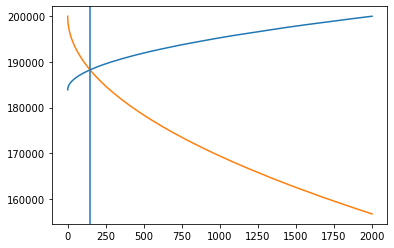

In [503]:
x = HS_bids['price'][0:1000]
y= HS_bids['Quantity'][0:1000]
x2 = HD_bids['price'][0:1000]
y2= HD_bids['Quantity'][0:1000]
plt.plot(x,y)
plt.plot(x2,y2)
plt.axvline(147)

In [504]:
HD_bids

,ID,OrderID,Hour,BitType,Quantity,price,Duration,LinkID
0,12,1000,1,S,156716.0,2000.00,1,NaN
1,12,999,1,S,156751.0,1996.76,1,NaN
2,12,998,1,S,156767.0,1995.25,1,NaN
3,12,997,1,S,156794.0,1992.78,1,NaN
4,12,996,1,S,156822.0,1990.18,1,NaN
...,...,...,...,...,...,...,...,...
23995,242,5,24,S,199186.0,6.50,1,NaN
23996,242,4,24,S,199270.0,5.22,1,NaN
23997,242,3,24,S,199466.0,2.79,1,NaN
23998,242,2,24,S,199637.0,1.29,1,NaN


In [505]:
HS_bids['Quantity'][0]-HD_bids['Quantity'][1000]

-7861.0

In [506]:
def Pairs(postion,Hour,DF,QP):
    
    if QP == 'DQ':
        DF=DF.iloc[HIndex_D[Hour][0]:HIndex_D[Hour][1]+1]
        return [DF['Quantity'][postion+HIndex_D[Hour][0]],DF['Quantity'][postion+1+HIndex_D[Hour][0]]]
    if QP == 'SQ':
        DF=DF.iloc[HIndex_S[Hour][0]:HIndex_S[Hour][1]+1]
        return [DF['Quantity'][postion+HIndex_S[Hour][0]],DF['Quantity'][postion+1+HIndex_S[Hour][0]]]
    if QP == 'DP':
        DF=DF.iloc[HIndex_D[Hour][0]:HIndex_D[Hour][1]+1]
        return [DF['price'][postion+HIndex_D[Hour][0]],DF['price'][postion+1+HIndex_D[Hour][0]]]
    else:
        DF=DF.iloc[HIndex_S[Hour][0]:HIndex_S[Hour][1]+1]
        return [DF['price'][postion+HIndex_S[Hour][0]],DF['price'][postion+1+HIndex_S[Hour][0]]]
    
Delta_S = np.zeros([len(BS_bids),24])


Delta_D = np.zeros([len(BD_bids),24])
BD_bids  = Blockbid()[1]
for i in range (len(BD_bids)):
    if BD_bids['Hour'][i]+BD_bids['Duration'][i]<=25:
        Delta_D[i,BD_bids['Hour'][i]-1:(BD_bids['Hour'][i]+BD_bids['Duration'][i])-1] = 1

BS_bids = Blockbid()[0]
for i in range (len(BS_bids)):
    if BS_bids['Hour'][i]+BS_bids['Duration'][i]<=25:
        Delta_S[i,BS_bids['Hour'][i]-1:(BS_bids['Hour'][i]+BS_bids['Duration'][i])-1] = 1

In [507]:
x=np.zeros(10)
x[1]=1
list(x)

[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [508]:
# Heuristic Algorithm for flexible bids

    
def HA_FB():
    temp1 = []
    for i in range(len(FS_bids)):
        temp1.append(random.randint(0,23))
        
    temp2 = []
    for i in range(len(FD_bids)):
        temp2.append(random.randint(0,23))
    res1 = []
    res2 = []
    for h in range(24):
        t1=np.zeros(len(FS_bids))
        t2=np.zeros(len(FD_bids))
        x1=np.where(np.array(temp1)==h)[0]
        x2=np.where(np.array(temp2)==h)[0]
        for j in x1:
            t1[j]=1
        res1.append(list(t1))
        for k in x2:
            t2[k]=1
        res2.append(list(t2))
    return res1,res2

In [509]:
NoneChild_D=[]
Child_D = []
Parent_D=[]
NoneChild_S=[]
Child_S=[]
Parent_S=[]
for i in range(len(BD_bids)):
    if BD_bids.isnull()['LinkID'][i] == True:
        NoneChild_D.append(i)
    else:
        Parent_D.append(np.where(BD_bids['ID']==BD_bids['LinkID'][i])[0][0])
        Child_D.append(i)
for i in range(len(BS_bids)):
    if BS_bids.isnull()['LinkID'][i] == True:
        NoneChild_S.append(i)
    else:
        Parent_S.append(np.where(BS_bids['ID']==BS_bids['LinkID'][i])[0][0])
        Child_S.append(i)

In [593]:
import pandas as pd


def build_tree(df):
    nodes = {}
    for idx, row in df.iterrows():
        node_id = row['ID']
        parent_id = row['LinkID']
        # nodes[node_id] = {'parent': parent_id, 'children': [], 'data': row}
        nodes[node_id] = {'parent': parent_id, 'children': []}

        if not pd.isnull(parent_id):
            if parent_id not in nodes:
                nodes[parent_id] = {'parent': None, 'children': [], 'data': None}
            nodes[parent_id]['children'].append(node_id)
    return nodes

In [510]:
# Heuristic Algorithm for Block bids


def HA_B():

    BD=[ 0 for i in range(len(BD_bids))]
    BS=[ 0 for i in range(len(BS_bids))]
    for i in NoneChild_D:
        BD[i] = random.randint(0,1)
    for i in NoneChild_S:
        BS[i] = random.randint(0,1)
    return BS,BD

In [511]:
def find_f(a1,a2,b1,b2,x):
    grad = (b2-b1)/(a2-a1)
    b = b2-grad*a2
    return grad*x+b

def aggregate(h,BS,BD,FS,FD):
    
    a = 0+h*1000
    b = 1000+h*1000
    agg_q=[]
    agg_p = []
    y1=list(reversed(HD_bids['Quantity'][a:b].tolist()))
    y2=HS_bids['Quantity'][a:b].tolist()
    x1 = list(reversed(HD_bids['price'][a:b].tolist()))
    x2 = HS_bids['price'][a:b].tolist()
    
    # add Block
    for i in range(len(BS)):
        if BS[i] * Delta_S[i][h] >0:
            k = BS_bids['Quantity'][i]
            y2 = list(map(lambda x:x+k,y2))
            # for j in range(len(y2)):
            #     y2[j]=y2[j]+BS_bids['Quantity'][i]
    
    for i in range(len(BD)):
        if BD[i] * Delta_D[i][h] >0:
            k= BD_bids['Quantity'][i]
            y1 = list(map(lambda x:x+k,y1))
            # for j in range(len(y1)):
            #     y1[j]=y1[j]+BD_bids['Quantity'][i]
    # #  add Flex
    for i in range(len(FS[h])):
        if FS[h][i] == 1:
            k = FS_bids['Quantity'][i]
            y2 = list(map(lambda x:x+k,y2))
    for i in range(len(FD[h])):
        if FD[h][i] ==1:
            k = FD_bids['Quantity'][i]
            y1 = list(map(lambda x:x+k,y1))

    
    for i in range(1000):
        if x1[i]==x2[i]:
            agg_q.append(y1[i]-y2[i])
            agg_p.append(x1[i])
        elif x1[i]<x2[i]:
            temp = find_f(x2[i-1],x2[i],y2[i-1],y2[i],x1[i])
            agg_q.append(y1[i]-temp)
            agg_p.append(x1[i])
            temp = find_f(x1[i],x1[i+1],y1[i],y1[i+1],x2[i])
            agg_q.append(temp-y2[i])
            agg_p.append(x2[i])
        elif x2[i]<x1[i]:
            temp = find_f(x1[i-1],x1[i],y1[i-1],y1[i],x2[i])
            agg_q.append(temp-y2[i])
            agg_p.append(x2[i])
            temp = find_f(x2[i],x2[i+1],y2[i],y2[i+1],x1[i])
            agg_q.append(y1[i]-temp)
            agg_p.append(x1[i])
    # while agg_q[0]*agg_q[-1]>=0:
    #     raise Exception("no root")
    for i in range(len(agg_q)-1):
        if agg_q[i]*agg_q[i+1] <0:
            grad = (agg_q[i+1]-agg_q[i])/(agg_p[i+1]-agg_p[i])
            b= agg_q[i+1] - agg_p[i+1]*grad
            Res = -b/grad          
            return Res
        

$$\left[[HS][HD][FS][FD][BS][BD] \right]$$

In [512]:

def generate_population():
    restart = True
    while restart:
        restart = False
        population = [[] for i in range(4)]
        BS,BD = HA_B()
        FS,FD = HA_FB()
        
        
        population[2]=FS
        population[3]=FD
        
        population.append(BS)
        population.append(BD)
        
        HS = [np.zeros(999).tolist() for i in range(24)]
        HD = [np.zeros(999).tolist() for i in range(24)]
        
        for h in range(24):
            price = aggregate(h,BS,BD,FS,FD)
            if price == None:
                # print('regenerate')
                restart = True
                break
            BS_INT = np.where(HS_bids['price'][h*1000:1000+h*1000]>price)[0][0]
            breakpoint_S = BS_INT + (price-HS_bids['price'][BS_INT-1+1000*h])/abs((HS_bids['price'][BS_INT+1000*h]-HS_bids['price'][BS_INT-1+1000*h]))-1
            
            BD_INT = np.where(HD_bids['price'][h*1000:1000+h*1000]>price)[0][-1]
            breakpoint_D = BD_INT + 1-(price-HD_bids['price'][BD_INT+1+1000*h])/abs((HD_bids['price'][BD_INT+1000*h]-HD_bids['price'][BD_INT+1+1000*h]))
            
            HS[h][0:int(breakpoint_S)]=np.ones(int(breakpoint_S))
            HS[h][int(breakpoint_S)]=breakpoint_S-int(breakpoint_S)
            
            HD[h][0:int(breakpoint_D)]=np.ones(int(breakpoint_D))
            HD[h][int(breakpoint_D)]=breakpoint_D-int(breakpoint_D)
            
        population[0] = HS
        population[1] = HD
        
    return population

In [513]:
def fit(population):
    Error = False
    #objective value 
    gamma = 100000
    Hour_S = population[0]
    Hour_D = population[1]
    Block_S = population[4]
    Block_D = population[5]
    Flex_S = population[2]
    Flex_D = population[3]
    
    
    Res_HD = sum(0.5*(2*HD_bids['price'][1000*i+j]+Hour_D[i][j]*(HD_bids['price'][1000*i+j+1]-HD_bids['price'][1000*i+j]))*Hour_D[i][j]*(HD_bids['Quantity'][1000*i+j+1]-HD_bids['Quantity'][1000*i+j]) for j in range(999) for i in range(24))                
    Res_HS = sum(0.5*(2*HS_bids['price'][1000*i+j]+Hour_S[i][j]*(HS_bids['price'][1000*i+j+1]-HS_bids['price'][1000*i+j]))*Hour_S[i][j]*(HS_bids['Quantity'][1000*i+j+1]-HS_bids['Quantity'][1000*i+j]) for j in range(999) for i in range(24))  
     
    Res_BD = sum(BD_bids['Duration'][i]*BD_bids['Quantity'][i]*BD_bids['price'][i]*Block_D[i] for i in range(len(Block_D))) 
    Res_BS =  sum(BS_bids['Duration'][i]*BS_bids['Quantity'][i]*BS_bids['price'][i]*Block_S[i] for i in range(len(Block_S)))
    
    Res_FD = sum(FD_bids['Quantity'][i]*FD_bids['price'][i] *sum(Flex_D[h][i] for h in range(24)) for i in range(len(FD_bids))) 
    Res_FS = sum(FS_bids['Quantity'][i]*FS_bids['price'][i] *sum(Flex_S[h][i] for h in range(24)) for i in range(len(FS_bids)))
    
    BA = sum(Pair(1,h,HD_bids,'DQ')[0]-Pair(1,h,HD_bids,'DP')[0] for h in range(24))
    OBJ_V = Res_HD - Res_HS + Res_BD - Res_BS + Res_FD - Res_FS + BA
    price=[]
    for h in range(24):
        price.append(aggregate(h,Block_S,Block_D,Flex_S,Flex_D))
        if aggregate(h,Block_S,Block_D,Flex_S,Flex_D)==None:
            print('AGG Error',end='')
            Error=True
            
    
    for i in Child_D:
        if Block_D[i]==1:
            x= np.where(BD_bids['ID']==BD_bids['LinkID'][i])[0][0]
            if Block_D[x]!=1:
                Error = True
                print('D Parent check fail',i)
                
    # for i in range(len(Child_D)):
    #     if Block_D[Child_D[i]]== 1:
    #         if Block_D[Parent_D[i]]!=1:
    #             Error = True
    #             print('D Parent check fail',i,Child_D[i],Block_D[Child_D[i]],Block_D[Parent_D[i]])
                
    for i in range(len(Child_S)):
        if Block_S[Child_S[i]]== 1:
            if Block_S[Parent_S[i]]!=1:
                Error = True
                print('S Parent check fail',i,end='')
                
                break
    
  
    # penalty by constarint
    Penalty = 0
    #  # penalty for constraint 6-7    
    for h in range(24):
        x = sum((HS_bids['price'][1000*h+j+1]-HS_bids['price'][1000*h+j]) * Hour_S[h][j] for j in range(len(Hour_S[h])-1))
        y = 2000+sum((HD_bids['price'][1000*h+j+1]-HD_bids['price'][1000*h+j]) * Hour_D[h][j] for j in range(len(Hour_D[h])-1))
        for i in range(len(FS_bids)):
            if x-FS_bids['price'][i] > gamma*sum(Flex_S[k][i] for k in range(24)):
                # print('FS Error',end='')
                Error = True
                break
        for i in range(len(FD_bids)):
            if FD_bids['price'][i]-x > gamma*sum(Flex_D[k][i] for k in range(24)):
                # print('FD Error',end='')
                Error = True
                break        
        # if round(x,5) == round(y,5):
        #     Error=False
        # else:
        #     Error=True
    return OBJ_V,Error,price

In [514]:
Sol_set= []
for i in tqdm(range(100)):
    Sol_set.append(generate_population())

100%|██████████| 100/100 [00:16<00:00,  6.04it/s]


In [515]:

for i in tqdm(range(100)):
    Sol_set[i].append(fit(Sol_set[i])[0])

100%|██████████| 100/100 [01:25<00:00,  1.17it/s]


In [516]:
def cross(A,B,SLD_size):
    List1 = copy.deepcopy(A)
    List2 = copy.deepcopy(B)
    for i in range(2,4):
        for h in range(24):
            begin = random.randint(SLD_size,len(List1[i][h])-SLD_size)
            temp = List1[i][h][begin:begin+SLD_size] 
            List1[i][h][begin:begin+SLD_size]=List2[i][h][begin:begin+SLD_size]
            List2[i][h][begin:begin+SLD_size] = temp
    for i in range(4,6):
        begin = random.randint(SLD_size,len(List1[i])-SLD_size)
        temp =List1[i][begin:begin+SLD_size] 
        List1[i][begin:begin+SLD_size]=List2[i][begin:begin+SLD_size]
        List2[i][begin:begin+SLD_size] = temp
    return List1,List2
    


In [693]:
def mut(pop):
    temp = copy.deepcopy(pop)
    Pm = 0.03
    BD_Tree = build_tree(BD_bids)
    BS_Tree = build_tree(BS_bids)
    for i in range(len(BS_bids)):
        if np.random.rand(1)<Pm:
            ID = BS_bids['ID'][i]
            if temp[4][i] == 0:
                if np.isnan(BS_Tree[ID]['parent'])==False and BS_Tree[ID]['parent'] !=0:
                    # Loc = np.where(BS_bids['ID']==int(BS_Tree[ID]['parent']))[0][0]
                    # temp[4][Loc]=1
                    temp[4][i]=1   
            if temp[4][i] == 1:
                if len(BS_Tree[ID]['children'])!= 0:
                    CL=BS_Tree[ID]['children']
                    for k in range(len(CL)):
                        temp[4][np.where(BS_bids['ID']==int(CL[k]))[0][0]]=0
                temp[4][i]=0
                
    for i in range(len(BD_bids)):
        if np.random.rand(1)<Pm:
            ID = BD_bids['ID'][i]
            if temp[5][i] == 0:
                if np.isnan(BD_Tree[ID]['parent'])==False and BD_Tree[ID]['parent'] !=0:
                    # Loc = np.where(BD_bids['ID']==int(BD_Tree[ID]['parent']))[0][0]
                    # temp[5][Loc]=1
                    temp[5][i]=1   
            if temp[5][i] == 1:
                if len(BD_Tree[ID]['children'])!=0:
                    CL=BD_Tree[ID]['children']
                    for k in range(len(CL)):
                        temp[5][np.where(BD_bids['ID']==int(CL[k]))[0][0]]=0
                temp[5][i]=0
                                
    for i in range(2,4):
        for j in range(24):
            for k in range(len(temp[i][j])):
                    if np.random.rand(1)<Pm:
                        temp[i][j][k]=int(not temp[i][j][k])
                
        
    return temp

In [ ]:
link= []
for i in range(len(BD_bids)):
    temp=[]
    while next != None:
        if BD_bids.isnull()['LinkID'][i]== True:
            temp.append(i)
            link.append(temp)
            next = None
        else:
            next=BD_bids['LinkID'][i]
            

In [681]:
B=build_tree(BD_bids)
CL = B[1217]['children']
for i in range(len(CL)):
    print(np.where(BD_bids['ID']==int(CL[i]))[0][0])

2
119


In [523]:
def select():
    p = random.sample(range(0,100),2)
    if Sol_set[p[0]][-1]>Sol_set[p[1]][-1]:
        return Sol_set[p[0]]
    else:
        return Sol_set[p[1]]

    

In [689]:
Sol_set1 = copy.deepcopy(Sol_set)

In [525]:
np.shape(Sol_set1)

/Users/weiliang/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


(100, 7)

In [ ]:
sorted_id = sorted(range(len(Sol_set)), key=lambda k: Sol_set[k][6], reverse=True)

Sub_pop = []
for i in tqdm(range(10)):
    Error= True
    while Error!=False:
        # cross
        p1 = select()
        p2 = select()
        
        p1,p2 = cross(p1,p2,2)
        if fit(p2)[1] == False and fit(p1)[1] == False:
            Error = False
            print('1 complete')
        
    Error =True
    while Error!= False:
        p1 = mut(p1)
        p2 = mut(p2)
        # mark
        if fit(p2)[1] == False and fit(p1)[1] == False:
            Error = False
            p1.append(fit(p1)[0])
            p2.append(fit(p2)[0])
    Sol_set1.append(p1)
    Sol_set1.append(p2)

In [694]:
sorted_id = sorted(range(len(Sol_set)), key=lambda k: Sol_set[k][6], reverse=True)

Sub_pop = []
for i in tqdm(range(10)):
    Error= True
    while Error!=False:
        # cross
        p1 = select()
        p2 = select()
        
        p1,p2 = cross(p1,p2,2)
        #mut
        p1 = mut(p1)
        p2 = mut(p2)
        # mark
        if fit(p2)[1] == False and fit(p1)[1] == False:
            Error = False
            p1.append(fit(p1)[0])
            p2.append(fit(p2)[0])
    Sol_set1.append(p1)
    Sol_set1.append(p2)
        
        
        
    

  0%|          | 0/10 [00:00<?, ?it/s]

AGG ErrorAGG Error

 10%|█         | 1/10 [00:22<03:23, 22.66s/it]

In [ ]:
np.shape(Sol_set1[119])

(7,)

In [ ]:
sorted_id = sorted(range(len(Sol_set1)), key=lambda k: Sol_set[k][6], reverse=True)

IndexError: list index out of range

In [ ]:
# 按列表a中元素的值进行排序，并返回元素对应索引序列

sorted_id = sorted(range(len(Sol_set)), key=lambda k: Sol_set[k][6], reverse=True)
print('元素索引序列：', sorted_id)


In [ ]:
x = list(np.arange(20))
y = list(np.zeros(20))

In [ ]:
select(x,y,4)

In [ ]:

%lprun -T lprof0 -f select 
print(open('lprof0', 'r').read())